<a href="https://colab.research.google.com/github/jhou27/NLP_with_Python/blob/main/Text_Classification_with_BERT_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Here we use a pre-trained BERT model from HuggingFace for a text classfication task.

#use a dataset of news and lables for each text


In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('/content/drive/My Drive/coding/bbc-text.csv')
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


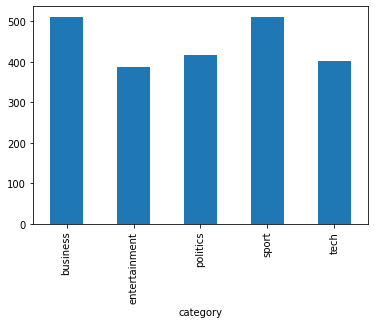

In [3]:
df.groupby(['category']).size().plot.bar()

In [4]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 3.9 MB/s 
     |████████████████████████████████| 120 kB 17.2 MB/s 
     |████████████████████████████████| 6.6 MB 32.6 MB/s 


In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#take a look at how berttokenizer tokenize text
example_text = 'I will watch a movie tonight'
bert_input = tokenizer(example_text,padding='max_length',max_length = 10,
                       truncation = True, return_tensors='pt')

print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[ 101,  146, 1209, 2824,  170, 2523, 3568,  102,    0,    0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


padding : to pad each sequence to the maximum length that you specify 

return_tensors : the type of tensors that will be returned. Since we’re using Pytorch, then we use pt. If use Tensorflow, then you need to use tf

input_ids: the id representation of each token [CLS],word, word ...[SEP] [PAD]

token_type_ids: a binary mask that identifies in which sequence a token belongs. If we only have a single sequence, then all of the token type ids will be 0

attention_mask: a binary mask that identifies whether a token is a real word or just padding.

#Dataset Clase
buid a dataset class for the news dataset taht will serve as a class to generate news data

In [6]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

After defining dataset class, let’s split our dataframe into training, validation, and test set with the proportion of 80:10:10.

In [7]:
np.random.seed(112)
#split[x,y] Split the array at positions x, y, so 0.8,0.9 results in 0-0.8 for 
#train, then 0.8-0.9 for val, then 0.9-1 for test
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


#Model building
Now let’s build the actual model using a pre-trained BERT base model which has 12 layers of Transformer encoder.

In [8]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

The first variable, which we named _ in the code above, contains the embedding vectors of all of the tokens in a sequence

The second variable, which we named pooled_output, contains the embedding vector of [CLS] token. For a text classification task, it is enough to use this embedding as an input for our classifier.


We then pass the pooled_output variable into a linear layer with ReLU activation function. At the end of the linear layer, we have a vector of size 5, each corresponds to a category of our labels (sport, business, politics, entertainment, and tech).

#Training Loop
We train the model for 5 epochs and we use Adam as the optimizer, while the learning rate is set to 1e-6. We also need to use categorical cross entropy as our loss function since we’re dealing with multi-class classification.

In [9]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [03:21<00:00,  4.41it/s]


Epochs: 1 | Train Loss:  0.762                 | Train Accuracy:  0.316                 | Val Loss:  0.674                 | Val Accuracy:  0.464


100%|██████████| 890/890 [03:19<00:00,  4.46it/s]


Epochs: 2 | Train Loss:  0.523                 | Train Accuracy:  0.680                 | Val Loss:  0.317                 | Val Accuracy:  0.932


100%|██████████| 890/890 [03:19<00:00,  4.46it/s]


Epochs: 3 | Train Loss:  0.204                 | Train Accuracy:  0.961                 | Val Loss:  0.109                 | Val Accuracy:  0.991


100%|██████████| 890/890 [03:19<00:00,  4.47it/s]


Epochs: 4 | Train Loss:  0.093                 | Train Accuracy:  0.979                 | Val Loss:  0.066                 | Val Accuracy:  0.991


100%|██████████| 890/890 [03:19<00:00,  4.46it/s]


Epochs: 5 | Train Loss:  0.053                 | Train Accuracy:  0.992                 | Val Loss:  0.049                 | Val Accuracy:  0.986


#Evaluate Model on test data

In [10]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.987
